In [1]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math
import keras
import tensorflow

from NN_utils import BigTable, WeightClip

import pickle
import zlib

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")


from sklearn.svm import SVR


def calc_probs_from_embs(students,questions):
    students2 = numpy.repeat(students, len(questions), axis=0)
    questions2 = numpy.tile(questions, (len(students),1))
    zmask = numpy.isclose(questions2,-10).astype(int)
    diffs = students2-questions2
    prs = 1.0/(1.0+ numpy.exp(-diffs))
    prs = numpy.maximum(zmask,prs)
    probs2 = numpy.prod(prs, axis=1).reshape(len(students), len(questions))
    return probs2


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


started


In [2]:
# from numpy.random import uniform, random_integers
# from scipy.stats import truncnorm

# def gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits):
#     students = numpy.zeros((n_students, n_factors))
#     for six in range(n_students):
# #         true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
#         true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
#         for cix,c in zip(range(n_factors), true_comps):
#             students[six,cix] = c

#     questions = numpy.zeros((n_questions, n_factors))
#     for qix in range(n_questions):
# #         n_comps = randint(min_active_traits, max_active_traits)
#         n_comps = n_factors
#         comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
#         true_comps = numpy.random.uniform(a0[0],a0[1], size=n_comps)

#         for cix,c in zip(comp_ixs,true_comps):
#             questions[qix,cix] = c#+boost
    
#     print("genqs",students.shape, questions.shape)
#     return students, questions

# def gen_bayes_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
#     students, questions = gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits)
#     print(students.shape, questions.shape)
#     obs = numpy.zeros((len(students), len(questions)))
#     probs = numpy.zeros((len(students), len(questions)))
#     vz = []
#     mz = []
#     scz =[]
#     for vi in range(len(students)):
#         for mi in range(len(questions)):
#             prs = (1-questions[mi]) + (questions[mi]*students[vi])
#             pr = numpy.prod(prs)
#             obs[vi,mi] = (random.random() < pr)
#             probs[vi,mi] = pr
#     return obs, probs, students, questions

# # n_students, n_questions, n_factors, min_active, max_active = 100,100,10,10,10

In [36]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w):
    students = numpy.zeros((n_students, n_factors))
#     for six in range(n_students):
#         true_comps = numpy.random.normal(0, a1, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
#         for cix,c in zip(range(n_factors), true_comps):
#             students[six,cix] = c

    students = numpy.random.normal(0, a1, size=(n_students,n_factors))
            
    av_c = (min_active_traits + max_active_traits)/2
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    
    questions = numpy.zeros((n_questions, n_factors)) - 10
    
    minb=-(test_w/2) -a0 - d50
    maxb=(test_w/2) -a0 - d50
    questions = questions
    minb, maxb = sorted([minb, maxb])
    minb = float(minb)
    maxb = float(maxb)
    
    for qix in range(n_questions):
        n_comps = randint(min_active_traits, max_active_traits)
#         print("n_comps", n_comps)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)  
#         print("range=", minb,maxb)
        true_comps = numpy.random.uniform(minb, maxb, size=n_comps)
        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c
            
    return students, questions

def gen_rasch_run(n_factors, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w=test_w)
    obs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    
#     students2 = numpy.repeat(students, n_questions, axis=0)
#     questions2 = numpy.tile(questions, (n_students,1))
    
# #     print("st and qn shapes:")
# #     print(students.shape)
# #     print(questions.shape)
    
#     zmask = numpy.isclose(questions2,-10).astype(int)
# #     print("zmask shape:", zmask.shape)
#     diffs = students2-questions2
# #     print("diffs shape:", diffs.shape)
#     prs = 1.0/(1.0+ numpy.exp(-diffs))
#     prs = numpy.maximum(zmask,prs)
#     probs2 = numpy.prod(prs, axis=1).reshape(n_students, n_questions)
        
    probs2 = calc_probs_from_embs(students, questions)
#     probs2 = None
    
#     for vi in range(len(students)):
#         for mi in range(len(questions)):
#             zmask = numpy.isclose(questions[mi],-10).astype(int)
#             diffs = students[vi]-questions[mi]
#             prs = logistic(diffs,1,0)
#             prs = numpy.maximum(zmask,prs)

#             pr = numpy.prod(prs)
#             obs[vi,mi] = (random.random() < pr)
#             probs[vi,mi] = pr
            
    return obs, probs2, students, questions



In [4]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Dense
from keras import backend as K, Model
from keras.optimizers import Adam
def generate_offset_generator(w=5,d=4):
    #width, dispersal, target_EV
    h=None
    inp = Input(shape=(3,))
    for _ in range(d):
        if h==None:
            h = Dense(w, activation="relu")(inp)
        else:
            h = Dense(w, activation="relu")(h)
    last_layer=inp if (h is None) else h
    offset = Dense(1, activation="linear")(last_layer)
    model = Model(inputs=[inp], outputs=[offset])
    model.compile(optimizer=Adam(), loss="mse")
    print(model.summary())
    return model

In [37]:
# a1 = 5/3
# a0 = 1.75
# tw = 3.5
from sklearn.metrics import mean_squared_error

from keras.callbacks import EarlyStopping
def create_offset_generator(n_factors, min_active, max_active, sampsize=14, n_iter=20000, rasch=True):
    n_questions = int(sampsize / 0.9)
    n_students = int(sampsize / 0.9)
    inps = []
    outs = []

    i=0
#     for a in range(n_iter):
    print("generating generator training mini-datasets...")
    n_dropped = 0
    while i < n_iter:

#         tw = random.uniform(0, 5)
#         a0 = random.uniform(-4, 5)
#         a1 = random.uniform(.5, 4)

        tw = random.uniform(0, 5)
        a0 = random.uniform(-5, 5)
        a1 = random.uniform(0, 4)

#         tw = random.uniform(0, 10)
#         a0 = random.uniform(-10, 10)
#         a1 = random.uniform(0, 10)


#         print(tw,a1,"...",a0)
        
        if rasch:
            _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
        else:
            _, _, students_temp, qz_temp  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)

        students2 = students_temp
        questions = qz_temp


        obs = (random.random() < probs).astype(int)
        exp_ob = numpy.mean(probs.flatten())
        if exp_ob <= 0.1 or exp_ob >= 0.9:
            n_dropped +=1
            continue
        i+=1
            
#         hard =numpy.round(probs)
#         plt.hist(hard.flatten())
#         plt.show()

#         agt = 0 #numpy.zeros_like(probs)
#         n_agt_runs = 20
#         for _ in range(n_agt_runs):
#             this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
# #             plt.hist(this_obs.flatten())
# #             plt.show()
#             this_agt = numpy.mean(((hard==this_obs).astype(float)).flatten())
# #             this_agt= numpy.std(probs.flatten() -0.5 )
# #             print("Agt:", this_agt)
#             agt += this_agt 
#         agt /= n_agt_runs
        
#         plt.hist(probs.flatten())
#         plt.show()
#         print("tw, a1, a0", tw, a1, a0)
#         print("Mean agt:", agt)
#         print("Exp pr:", exp_ob)
        
        
        print(i, exp_ob)
        inps.append([tw,a1, exp_ob])
        outs.append(a0)
#         for p in probs.flatten():
#             inps.append([tw,a1, p])
#             outs.append(a0)
        
    print("done!")

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    
    split = len(inps)//10
    vinps = numpy.array(inps[split:])
    vouts = numpy.array(outs[split:])
    inps = numpy.array(inps[:split])
    outs = numpy.array(outs[:split])
    print(inps.shape, outs.shape)

    best_mse = math.inf
    best = None
    best_dims = None
#     seen = set()
                        
    for nnw in [16]: # [2,4,8,16,32]:
        for nnd in [2]: #[0,1,2,3,5]:
#             if (nnw,nnd) in seen:
#                 continue
#             seen.add((nnw,nnd))
            gen_m = generate_offset_generator(nnw, nnd)
            h = gen_m.fit(inps,outs, epochs=10000, shuffle=True, batch_size=len(inps), callbacks=[es], validation_split=0.1, verbose=1)
            
#             gen_m = SVR()
#             gen_m.fit(inps, outs)
            
            mse = mean_squared_error(vouts,gen_m.predict(vinps))
            if mse < best_mse:
                print("new best:",nnw,nnd,":",mse)
                best_mse = mse
                best_dims = (nnw,nnd)
                best = gen_m
    
    predz = best.predict(inps)
#     for i,p,o in zip(inps,predz, outs):
#         print(i, p, o)
    print("Best generator for", (n_factors, min_active, max_active), "is", best_dims)
    print("avg", numpy.mean(outs), "vs", numpy.mean(predz))
    print("number of extreme cases = ", n_dropped, "as prop of ",n_iter," iters", n_dropped/n_iter)
    print(mean_squared_error(vouts, best.predict(vinps)))
    
    h=None
    return best, h, best_dims, best_mse

In [6]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    print(split, real_wgts.shape, pred_wgts.shape, max_iter)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [7]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    if real_items.shape[1]<2:
        print("real_items is only 1 component wide .. needs to be >1 to plot on a PCA graph")
        return None
    elif real_items.shape[1]==2:
        print("2 comps, so no dim reduc")
        tx=None
    else:
        tx = PCA(n_components=2)
#         tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    print("pred list shape", pred_list.shape)
    print("real items shape", real_items.shape)


    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = real_items
    n = len(real_items)
    
    for opreds in pred_list:
        preds = copy.copy(opreds) #- s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
#         itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         if itemz_2 is None:
#             itemz_2 = numpy.concatenate([real_itemz, itemz_pred], axis=0)
#         else:
        itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        print("shape of itemz_2", itemz_2.shape)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="b", zorder=10, alpha=0.5)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>=1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
#                 print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]

In [8]:
def calc_probs(s,q):
    zmask = numpy.isclose(q,-10).astype(int)
    diff = s-q
    prs = 1.0/(1.0+ numpy.exp(-diff))
    prs = numpy.maximum(zmask,prs)
    pr = numpy.prod(prs, axis=-1).reshape(len(q))
    return pr
    
def stitch_n_split(_pairs, sts, qns, realise=True, rpt=False):
    out_w = 50
    max_fails = out_w -1
    if realise:
        if rpt:
            _counts = defaultdict(int)
            _matches=[]
            _pfz=[]
            _sz, _qz = [],[]
            cache = defaultdict(list)
            for (vi,mi) in _pairs:
                cache[vi].append(mi)
            
            for vi in cache:
                s = sts[vi]
                prs = calc_probs(s, [qns[k] for k in cache[vi]])  
#                 print("shape of prs", prs.shape)
                for mix,mi in enumerate(cache[vi]):
#                 pr = _probs[vi,mi]
                    pr = prs[mix]
                    rnd = random.random()
                    i=0
                    while rnd > pr and i<max_fails:
                        i += 1
                        rnd = random.random()

                    zs = numpy.zeros(max_fails+1)
                    zs[i] = 1
                    _counts[i] += 1

                    _pfz.append(zs)
    #                 _pfz.append(i)
                    _sz.append(vi)
                    _qz.append(mi)
            print("probs calced")
        else:
            _prob_list =  numpy.array([calc_prob(sts[vi],qns[mi]) for (vi,mi) in _pairs])
            _pfz = (numpy.random.random(len(_prob_list)) < _prob_list).astype(int)
    #     _pfz = (0.5 < _prob_list).astype(int)
            _matches = ( numpy.round(_prob_list) == _pfz).astype(int)
        print("realisation complete")
    else:
        _prob_list =  numpy.array([calc_prob(sts[vi],qns[mi]) for (vi,mi) in _pairs])
        _pfz = _prob_list
        _matches = numpy.ones_like(_prob_list)
        _sz = [p[0] for p in _pairs]
        _qz = [p[1] for p in _pairs]

#     print(_pfz)
#     _pfz = numpy.array([probs[vi,mi] for (vi,mi) in _pairs])

#     print(_matches)
#     print(numpy.sum(_matches), "correctly labelled out of", len(_matches), "%=", numpy.sum(_matches)/len(_matches))
    if not rpt:
        _sz = [p[0] for p in _pairs]
        _qz = [p[1] for p in _pairs]
    print("sns complete")
    
    one_c = _counts[1]
    for k in _counts:
        c = _counts[k]
        _counts[k] = one_c / c
    
    return numpy.array(_pfz), _sz, _qz, _counts

c [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
1 0.15 0.15
c [1 0 0 0 5 2 0 2 0 2 0 0 1 0 2 0 1 1 0 0]
9 0.45 0.85
c [1 1 1 2 6 3 2 3 2 3 1 0 1 1 3 1 2 1 0 0]
17 0.85 1.7
c [1 1 3 3 9 4 2 5 2 4 1 0 1 2 3 2 2 1 2 0]
25 0.9 2.4
c [ 2  2  3  4 10  5  4  6  4  4  2  0  2  3  3  3  2  2  4  0]
33 0.9 3.25
c [ 4  3  4  5 10  6  5  7  4  5  5  2  3  4  5  3  2  2  4  0]
42 0.95 4.15
c [ 4  4  5  5 10  7  5 10  5  6  5  4  4  5  7  3  3  3  5  1]
50 1.0 5.05
c [ 4  5  6  5 10  8  5 14  6  6  5  5  5  5  7  3  4  4  6  2]
58 1.0 5.75
c [ 5  6  7  6 12  9  6 14  7  6  5  5  5  6  8  3  4  6  6  3]
66 1.0 6.45
c [ 5  8  9  8 13 10  7 14  8  7  5  5  6  6  8  6  6  7  7  4]
75 1.0 7.45


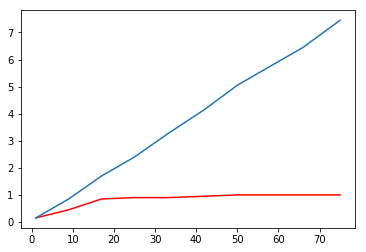

In [30]:
def calc_skills_coverage():
    xs=[]
    ys=[]
    ycnts=[]
    n_factors, min_active, max_active = 20,1,3
    n_students = 1
    tw=1
    a0=1
    a1=1
    max_n_qns = 75
    n_questions_list = numpy.linspace(1,max_n_qns,num=10).astype("int")

    _, _, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=max_n_qns)
    for n_questions in n_questions_list:
        cnt = numpy.array([False]*n_factors).astype("int")
#         plt.hist(qz_temp.flatten(), alpha=0.5)
#         plt.show()
        for q in qz_temp[0:n_questions]:
            active = (q > -10).astype("int")
#             print("a",active)
            cnt = cnt + active
            seen = numpy.clip(cnt, 0,1)
        print("c",cnt)
        print(n_questions, numpy.mean(seen), numpy.mean(cnt))
        xs.append(n_questions)
        ys.append(numpy.mean(seen))
        ycnts.append(numpy.mean(cnt))
    plt.plot(xs,ys, c="red")
    plt.plot(xs,ycnts)
    plt.show()
    
calc_skills_coverage()

In [13]:
gen_m_cache = pickle.load(open("generators.p", "rb"))

In [11]:
gen_m_cache = {}

In [41]:
tup = (20,1,3)
n_factors, min_active, max_active = tup

# sss = [10,20,30,50,70]
# nits = [1000,10000,50000]
sss = [70]
nits = [10000]


for ss in sss:
    for nit in nits:
        key = ((tup,(nit,ss)))
#         if key in gen_m_cache:
#             del gen_m_cache[key]
        print("creating genny")
        gen_m, history, best_dims, best_mse = create_offset_generator(n_factors, min_active, max_active, sampsize=ss, n_iter=nit)
        gen_m_cache[key] = (gen_m, history, best_dims, best_mse)

        # summarize history for loss
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
#         plt.title('Model loss for {}x{}'.format(ss,nit))
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper right')
#         plt.show()

creating genny
generating generator training mini-datasets...
1 0.18660409407158968
2 0.17361084206777086
3 0.8030473342156105
4 0.45863724890401336
5 0.23991255301844408
6 0.8593277142124477
7 0.6619458203965238
8 0.7931029543418155
9 0.8218302480400465
10 0.40809050478106285
11 0.7138521221314318
12 0.3249571111821234
13 0.43256164149239507
14 0.42673563638828427
15 0.5915964767264181
16 0.398714952956328
17 0.42430109149909256
18 0.7525956826379042
19 0.560163499656551
20 0.513398949404245
21 0.7434550288424737
22 0.8815644435872078
23 0.29606958980873166
24 0.5541339260474919
25 0.14555272098835254
26 0.5334930404076978
27 0.7361520703036531
28 0.1270896810522258
29 0.47886382328910226
30 0.8901015613955631
31 0.3806269469197174
32 0.13982350915900715
33 0.327419380368129
34 0.13252940096566032
35 0.515573608414094
36 0.3619735994144595
37 0.10735825757404724
38 0.8806514308472558
39 0.2878294598581978
40 0.2654583548189414
41 0.3938606935600817
42 0.3743991429893206
43 0.735343527

368 0.2478925597925315
369 0.6255741412937221
370 0.3720497248871898
371 0.8433075202245286
372 0.8277659737618571
373 0.6389897702663024
374 0.5601475365767808
375 0.4137416272339337
376 0.5608265569962716
377 0.24242251305935056
378 0.28624436808417314
379 0.5045162738036704
380 0.22438669667001268
381 0.1668654200882348
382 0.39273006745671313
383 0.7018327495232894
384 0.7153741181077171
385 0.2480367386153114
386 0.3326102036620694
387 0.12474360203558726
388 0.815385445785447
389 0.21220292707102734
390 0.14527962332224126
391 0.6943291482655886
392 0.22122498816533614
393 0.1657098251244743
394 0.420735433930539
395 0.11167431061814632
396 0.6004679533712997
397 0.2131699640974931
398 0.4437797595310563
399 0.7797114578558934
400 0.22441409893051956
401 0.7620363263558135
402 0.2804816663318946
403 0.5134871963164717
404 0.3940537780142868
405 0.850465941540613
406 0.14340533545045872
407 0.18970188719649408
408 0.7943140746588767
409 0.7405011616870968
410 0.16971462678899604
4

729 0.4057602951441921
730 0.5403020280050149
731 0.12561176815642563
732 0.40680880096239586
733 0.7928291143204916
734 0.4708865602767166
735 0.1555723468013892
736 0.8725978794890813
737 0.16880700599145565
738 0.7579260359757237
739 0.4488263372609609
740 0.16946470717986042
741 0.867011320010037
742 0.4278365349428709
743 0.5590628576556721
744 0.8095908572279902
745 0.30760463451999737
746 0.3149870136303903
747 0.6424422224967725
748 0.28028614038292354
749 0.6141346257214091
750 0.6704906830118288
751 0.6073348399707117
752 0.36513386408846105
753 0.8541273861741494
754 0.46190793853092177
755 0.5815808908460046
756 0.16298364451236472
757 0.7678519917766357
758 0.4086444123935239
759 0.5125518752068882
760 0.5842000099979179
761 0.3889486620102429
762 0.7868622338771761
763 0.6252193868303473
764 0.1399492639920852
765 0.6283392693755461
766 0.4239416028601007
767 0.21938181510134747
768 0.5414153636083076
769 0.22939585838685983
770 0.1812873517602459
771 0.5086217405195953
7

1083 0.2554292323911055
1084 0.3711258929632429
1085 0.3572335249590059
1086 0.4279778118955768
1087 0.6924463621161182
1088 0.7203950228855968
1089 0.47650418677020945
1090 0.6751629608568831
1091 0.8061170481285876
1092 0.20444059465750394
1093 0.33923048832898683
1094 0.5027119261561137
1095 0.8746950671294267
1096 0.11174235937639782
1097 0.14198172369667622
1098 0.11591331209755099
1099 0.5136031876053954
1100 0.1435822528411004
1101 0.7903914933007893
1102 0.18063336708241431
1103 0.1100311778212681
1104 0.8570237298143479
1105 0.5303925613203583
1106 0.6012052708794284
1107 0.367454884046314
1108 0.5394522316154403
1109 0.28334503625533913
1110 0.8267220716992959
1111 0.7628654866120774
1112 0.4844460831578909
1113 0.14887915481446368
1114 0.16821379593376862
1115 0.3305840331005654
1116 0.3815109060509119
1117 0.8597313984970544
1118 0.2543156037874688
1119 0.31643026392026335
1120 0.15852191848316358
1121 0.8363484821710255
1122 0.14930953864344346
1123 0.17823407527946836
112

1422 0.42394407428238856
1423 0.741137175039554
1424 0.14134557896462155
1425 0.14908239982364432
1426 0.5527201382831576
1427 0.2578702304975278
1428 0.6613756117588323
1429 0.8479649596666833
1430 0.4610774737175983
1431 0.608384631750942
1432 0.6956373140038368
1433 0.24024288439218577
1434 0.5071413828391347
1435 0.5996243241442707
1436 0.1819092009463987
1437 0.7535304407420806
1438 0.7234897963500182
1439 0.46056752130581063
1440 0.7023198839153018
1441 0.47799750817822256
1442 0.5273060360771374
1443 0.7786161410275995
1444 0.6692843659386358
1445 0.8428842925715736
1446 0.10156824718453783
1447 0.8669088934277626
1448 0.5524827751811403
1449 0.7560047119541369
1450 0.40003024803090664
1451 0.15769330175825857
1452 0.6415763932922014
1453 0.35508461861962254
1454 0.156575789425157
1455 0.764524398556641
1456 0.11199516433058002
1457 0.2552016348093035
1458 0.7191670772706015
1459 0.5010694413046796
1460 0.14993405594173256
1461 0.48134884737353134
1462 0.6331504166361922
1463 0.

1768 0.6024067933773705
1769 0.26609566068064555
1770 0.21696097666594183
1771 0.712359192455392
1772 0.18170301275869163
1773 0.36735291610247517
1774 0.14112307768659105
1775 0.26208936317871545
1776 0.3725266167565764
1777 0.7472944307338264
1778 0.8282032127466183
1779 0.11292766308353845
1780 0.5028940826985625
1781 0.2978645346245495
1782 0.38624328793741813
1783 0.8041521440904784
1784 0.8631759599095714
1785 0.2511445902062213
1786 0.3533773384336791
1787 0.19959346670160008
1788 0.37747478738506185
1789 0.7873657634730035
1790 0.7056353823795768
1791 0.7162176351262026
1792 0.19011178838147885
1793 0.3864112473378891
1794 0.8890645534965106
1795 0.714714310554126
1796 0.5845104357304294
1797 0.3881515729817402
1798 0.7655977862300185
1799 0.8708325660761763
1800 0.7535483497000762
1801 0.6121320775464313
1802 0.8541250737562971
1803 0.41934661530051925
1804 0.6958838369717226
1805 0.6896931630962194
1806 0.2510460490647146
1807 0.6996865115529808
1808 0.23123561899341577
1809 

2124 0.8395182782313665
2125 0.12569894064319387
2126 0.22477933720036977
2127 0.4526899095377885
2128 0.6793025380330474
2129 0.6134773280119814
2130 0.6030846576433678
2131 0.21736383385401203
2132 0.6991923687433572
2133 0.11376704650908237
2134 0.34877972135702245
2135 0.18903803411604986
2136 0.5998986140031267
2137 0.6461125620061777
2138 0.5289896522267149
2139 0.1200635183376213
2140 0.7817569535059213
2141 0.3471368512866022
2142 0.34067021059171837
2143 0.10158665322882543
2144 0.22080291182853354
2145 0.8145222388888086
2146 0.1313567412617881
2147 0.29381905450504686
2148 0.6890811565069829
2149 0.8872878737657186
2150 0.24429149964933633
2151 0.1582747706222482
2152 0.1896353556015409
2153 0.37027745880489604
2154 0.2554997646295323
2155 0.5044322250107685
2156 0.7109246645236926
2157 0.8929054391052822
2158 0.18728946412205527
2159 0.24900291012504247
2160 0.40917714283332224
2161 0.13096666656478634
2162 0.3050796692979722
2163 0.1512076899584243
2164 0.19460260627655931

2470 0.754496247683425
2471 0.13506452974777525
2472 0.6996022098024557
2473 0.7840182187956659
2474 0.8186471467346462
2475 0.712792298785161
2476 0.3686311768026242
2477 0.28176506333036866
2478 0.5513943582773232
2479 0.307302128905984
2480 0.5931919492351331
2481 0.1710473160458362
2482 0.7096010626723811
2483 0.18077001388595065
2484 0.6252883345157614
2485 0.4872007129870408
2486 0.6730004921034307
2487 0.68827910143443
2488 0.11763271826457623
2489 0.8780580095053501
2490 0.5680097782810749
2491 0.6952292381782549
2492 0.1999481160113189
2493 0.31071023806891035
2494 0.1674281280450851
2495 0.1609331656402336
2496 0.5504694804126112
2497 0.5621501176321103
2498 0.8827800803808266
2499 0.19618022063129542
2500 0.6881905451269
2501 0.19601259678868568
2502 0.5276004005424964
2503 0.19737198643011328
2504 0.1117180157011481
2505 0.5118187141131394
2506 0.8664755275072431
2507 0.27602331450317563
2508 0.4544263054239565
2509 0.10924996045194112
2510 0.8633937297114543
2511 0.3178906

2809 0.18837314233866775
2810 0.15590161913430428
2811 0.11295811123442998
2812 0.26315971959625506
2813 0.12111356976891914
2814 0.4893107591153733
2815 0.6646711449813053
2816 0.8920001096743608
2817 0.36428056472896425
2818 0.44389236415274813
2819 0.4749552009156576
2820 0.6972452585527427
2821 0.3754174477966612
2822 0.7525616474932696
2823 0.6802888198702476
2824 0.19325976444168103
2825 0.8403239653256476
2826 0.1320125219642729
2827 0.8824491084853674
2828 0.655627727182626
2829 0.23001446020606353
2830 0.5858426875589988
2831 0.42183641228041263
2832 0.8427296550624163
2833 0.7413482589887574
2834 0.10344768519285176
2835 0.17553736728442937
2836 0.5052858230679125
2837 0.2253135974078058
2838 0.11372228217631089
2839 0.1838890653720253
2840 0.41702792896841445
2841 0.6656069421588091
2842 0.8120763571683224
2843 0.587115645384919
2844 0.3805963301970173
2845 0.4006816512527905
2846 0.23060790041560192
2847 0.43582692832854614
2848 0.47063112968316817
2849 0.38042009185323983


3157 0.13794180203082254
3158 0.12625980657931712
3159 0.10550691209529854
3160 0.803491479473429
3161 0.8365337646242925
3162 0.7751824573093257
3163 0.23221210870755302
3164 0.46871506864407164
3165 0.43252726620281545
3166 0.5545689649912949
3167 0.3554803378482859
3168 0.11632098439589862
3169 0.2746122660380576
3170 0.2699423726958861
3171 0.7614288722002546
3172 0.38305947130634826
3173 0.1282096779451436
3174 0.46957676420579036
3175 0.5424252372082468
3176 0.6077576370429222
3177 0.3619534038129115
3178 0.7821152947209682
3179 0.6457975174845512
3180 0.8976364399337808
3181 0.28732562788547267
3182 0.18948767346427417
3183 0.4267224412379159
3184 0.8264224478236265
3185 0.3805550260308865
3186 0.898374468485746
3187 0.11227399255722664
3188 0.43307927836460297
3189 0.5424402685653731
3190 0.11665335198614686
3191 0.7441452738550605
3192 0.320330026373963
3193 0.4028126022723393
3194 0.8972650617810994
3195 0.3147305552932244
3196 0.18391903291161096
3197 0.8101793086612876
3198

3501 0.15616138488256673
3502 0.6066092830957563
3503 0.4093256226781097
3504 0.34627760210587966
3505 0.5251460249809466
3506 0.7219815334533869
3507 0.895306431979729
3508 0.1473027976666456
3509 0.1545546635190141
3510 0.8166083486066055
3511 0.8369677877927025
3512 0.42876084031936673
3513 0.5804242659029781
3514 0.1349715094892881
3515 0.14037690429793281
3516 0.7962520322743798
3517 0.25455408114472694
3518 0.41703655614277607
3519 0.48931780894380716
3520 0.3757423242186361
3521 0.7386635581071654
3522 0.4384508331888928
3523 0.11175431997449538
3524 0.8788267261480467
3525 0.8671989037546823
3526 0.7453222746248285
3527 0.8459097716295274
3528 0.7676574712966333
3529 0.11439001928066572
3530 0.44936071501197355
3531 0.7309467458187309
3532 0.4603991170270598
3533 0.28392687345437406
3534 0.6460540339212153
3535 0.4137623854420271
3536 0.17996770042138593
3537 0.6550384576147652
3538 0.8473279258425758
3539 0.16909859187163695
3540 0.20669526889746623
3541 0.7114123187164062
354

3841 0.3236008502826446
3842 0.10748138533116672
3843 0.582152044250064
3844 0.6120450711321336
3845 0.3436967984775089
3846 0.6179746195259975
3847 0.11910690574899631
3848 0.1639560021590071
3849 0.16954694254264124
3850 0.11611178314804574
3851 0.6190999549319142
3852 0.7208158121584541
3853 0.42952415070067135
3854 0.7034520465349092
3855 0.7252189234459457
3856 0.13604449125634896
3857 0.33098585860476
3858 0.4073663508771071
3859 0.8018941492357874
3860 0.14415302007141434
3861 0.8685436022288391
3862 0.4264050529609796
3863 0.28957030023204533
3864 0.8344419192772558
3865 0.12729661152123758
3866 0.7018257950644323
3867 0.781309100314594
3868 0.4742422660296433
3869 0.2557983615681534
3870 0.3420031337658995
3871 0.7470776025489707
3872 0.8510139648803882
3873 0.10082592656865284
3874 0.30302929080907837
3875 0.5642645541658179
3876 0.10887479827256533
3877 0.8835090522006199
3878 0.6543472630100541
3879 0.22946862886052338
3880 0.6912568896362475
3881 0.17919330189232915
3882 0

4192 0.33057855472448905
4193 0.3582448106156442
4194 0.2456001904185998
4195 0.8753733364193761
4196 0.735719112869083
4197 0.11014021565178156
4198 0.754548028148446
4199 0.18639869594278483
4200 0.10149214447424815
4201 0.7599248341179153
4202 0.2707394351291698
4203 0.7528921959352478
4204 0.842394924721831
4205 0.8172930017581994
4206 0.4349970896673382
4207 0.4660481008105346
4208 0.5572828838993761
4209 0.2330420350468707
4210 0.5949790240084194
4211 0.7922214512065793
4212 0.2046580195293231
4213 0.8750498214298971
4214 0.6844295554257468
4215 0.6460342566302438
4216 0.8428498609457344
4217 0.46322273170810496
4218 0.29665581956037856
4219 0.19304789641441547
4220 0.5316500608081431
4221 0.12084580858032551
4222 0.5926931443273005
4223 0.831457372865027
4224 0.43024619293101884
4225 0.27369712261074003
4226 0.2219947520490727
4227 0.26415027031124416
4228 0.8364550879966054
4229 0.8869940254835266
4230 0.2116578378038856
4231 0.14975512416674222
4232 0.8207852482453347
4233 0.8

4540 0.558250524047959
4541 0.6329587652806777
4542 0.13419079872628667
4543 0.704521068655716
4544 0.14698892956620552
4545 0.278056741251936
4546 0.2577235172625311
4547 0.8180764732851803
4548 0.15782708961553907
4549 0.2524796268597822
4550 0.19481071199253633
4551 0.8379784584536702
4552 0.7590463772569915
4553 0.5239529342409135
4554 0.13851874906465098
4555 0.806004126035995
4556 0.7498606202397351
4557 0.15067556766371823
4558 0.44121227397737556
4559 0.5280050362680686
4560 0.6421219232488709
4561 0.18249644974920357
4562 0.16845669361020274
4563 0.8541140504797723
4564 0.8904470785708309
4565 0.3403167516720816
4566 0.56536744298021
4567 0.13217651010721299
4568 0.2793714858913509
4569 0.6679851443322669
4570 0.8849312425160594
4571 0.15572242216148588
4572 0.18020960692304114
4573 0.7436079795214596
4574 0.15737391333185505
4575 0.6965202675710496
4576 0.33318431899019946
4577 0.5261854409114354
4578 0.7216781085890431
4579 0.6990304562069282
4580 0.19734709098739434
4581 0.

4879 0.8595770157246736
4880 0.8505793987986741
4881 0.34417293046873054
4882 0.39043853145442775
4883 0.8931207510448161
4884 0.6380934705993332
4885 0.17488345552292528
4886 0.530709759105981
4887 0.6070079315903756
4888 0.3196473634140049
4889 0.3859428382798976
4890 0.35125649684261384
4891 0.44337976733705
4892 0.8130987266138142
4893 0.38925838180966976
4894 0.20435274716506605
4895 0.6466523938980554
4896 0.785636904822413
4897 0.48664863630596095
4898 0.5551704104631221
4899 0.12418435626745494
4900 0.25711606981682206
4901 0.24319225276284315
4902 0.37184404484419753
4903 0.5534183046561787
4904 0.2396284561413874
4905 0.895600799748932
4906 0.7065776635599005
4907 0.6319071045421669
4908 0.5365931587066267
4909 0.6880049456896634
4910 0.6770883941310638
4911 0.8690784168569209
4912 0.22859078370489394
4913 0.4621730546546469
4914 0.3468731035593258
4915 0.15366908675471072
4916 0.7265906734270979
4917 0.8716276496206867
4918 0.697773797424763
4919 0.4157029762660614
4920 0.84

5232 0.7019944085049437
5233 0.3231496603785873
5234 0.2061745489192266
5235 0.3141028882549034
5236 0.7401370780473004
5237 0.4971700903300528
5238 0.1663121657839592
5239 0.6764686358747528
5240 0.8665830120964971
5241 0.4703800132978195
5242 0.6217331701117771
5243 0.8245392684202023
5244 0.5318236880999825
5245 0.5802102285412298
5246 0.4950120967712103
5247 0.727445112721724
5248 0.8061645581509268
5249 0.5211113798978577
5250 0.15036761430583026
5251 0.8241605489775692
5252 0.21005530528747374
5253 0.1101353451320289
5254 0.3192127516238499
5255 0.23950768140043338
5256 0.7102617677955751
5257 0.8503705725054632
5258 0.5819657196091544
5259 0.4272337624050976
5260 0.7952567330370583
5261 0.3663209002134573
5262 0.8351215402800781
5263 0.548343846738127
5264 0.32517911197910265
5265 0.168521656433047
5266 0.12719521328803685
5267 0.8057050542766495
5268 0.6516158825255886
5269 0.653750028495427
5270 0.374016737197331
5271 0.28689054870831504
5272 0.39526499620924876
5273 0.6856063

5577 0.6337422976654032
5578 0.5622797270816815
5579 0.48286205926413833
5580 0.25545914952953797
5581 0.13350045055185542
5582 0.8443415183854373
5583 0.634803655994707
5584 0.1545173102297457
5585 0.22547377778465566
5586 0.18490954370727597
5587 0.2526464219179913
5588 0.15754578492610533
5589 0.18611648082984766
5590 0.6542251624084433
5591 0.7687854425641785
5592 0.13431968938884292
5593 0.15887147105562327
5594 0.7482055225241937
5595 0.8548840370173749
5596 0.3925016085800026
5597 0.7436345973810363
5598 0.16021054671129345
5599 0.6547130958132302
5600 0.6584026292774747
5601 0.8477441460539019
5602 0.8650880476035769
5603 0.41536440542865005
5604 0.8716474823462799
5605 0.5516420615916009
5606 0.5811841178831685
5607 0.19335103745834387
5608 0.8404295569827268
5609 0.7131679695892142
5610 0.19647934813966145
5611 0.7464589479776431
5612 0.5854873490692182
5613 0.28126190828528147
5614 0.2426484265456494
5615 0.7977298044466714
5616 0.8915381660137962
5617 0.5512381237037288
561

5922 0.41968066193803244
5923 0.10791697923453099
5924 0.12391348255238915
5925 0.6234105328072027
5926 0.7683804533335439
5927 0.6937309046851777
5928 0.1489334317742402
5929 0.11630624098953256
5930 0.8898460984719037
5931 0.22920622497052898
5932 0.5164503013372369
5933 0.25368427824730266
5934 0.15602300383408235
5935 0.4112343118527915
5936 0.6102314322310269
5937 0.3872386999053366
5938 0.8945192452476542
5939 0.4712764089686576
5940 0.13198810549480838
5941 0.647736661909603
5942 0.6893420811387408
5943 0.17283219454803386
5944 0.30957037419112365
5945 0.5416902244073212
5946 0.6851721721722341
5947 0.23871829094498093
5948 0.8391714919273707
5949 0.24085282176998926
5950 0.49306403508255764
5951 0.14522661078244892
5952 0.16038232574141884
5953 0.5026132749889688
5954 0.7426014734653172
5955 0.18018243990277585
5956 0.8534992773344285
5957 0.17115258259932437
5958 0.7799258621859887
5959 0.4999914181807414
5960 0.7407094488050259
5961 0.3767544495501944
5962 0.35650618299868414

6271 0.7568472747054222
6272 0.1757585977965304
6273 0.1771618902264917
6274 0.12019386962312632
6275 0.3230310396568454
6276 0.6822170199326899
6277 0.7867231025737859
6278 0.8946858926123324
6279 0.4834851912291771
6280 0.3080065520659088
6281 0.15337955608928747
6282 0.7177518458854215
6283 0.7865064175250908
6284 0.3797187978676229
6285 0.19256835615811232
6286 0.45832813694358987
6287 0.812090559568514
6288 0.840298235465155
6289 0.8654362250863036
6290 0.5375682583613147
6291 0.12902963317575877
6292 0.4681973876153327
6293 0.8971350101477018
6294 0.10241336303405728
6295 0.2666416862599232
6296 0.7086192243742799
6297 0.6822907507188454
6298 0.25485333036323726
6299 0.6669292074262422
6300 0.567857902445637
6301 0.2803862798224463
6302 0.25386503130485205
6303 0.6292517585985039
6304 0.5650824506400599
6305 0.13952195719758861
6306 0.13632232940575983
6307 0.11781530215871365
6308 0.5674946746054192
6309 0.17761483897184277
6310 0.5738428008533162
6311 0.7592608465820226
6312 0.

6620 0.8166881688600778
6621 0.5212659046568348
6622 0.6760432236498658
6623 0.11913506661465907
6624 0.4256026702437533
6625 0.42982406882573315
6626 0.7255224896433726
6627 0.8032665847559748
6628 0.5254136889363278
6629 0.7836668590778844
6630 0.6661842224687875
6631 0.7474240340280885
6632 0.18532665212693852
6633 0.8502316871887257
6634 0.2867133043522558
6635 0.2434344051880187
6636 0.21553776032165328
6637 0.6500149091421739
6638 0.27322036953702555
6639 0.7161040706547811
6640 0.34558380976425485
6641 0.4228769919517154
6642 0.17568033617478543
6643 0.8521140620760996
6644 0.2967310330512035
6645 0.1243601778402124
6646 0.7393481519433641
6647 0.744512038507482
6648 0.36441890829124696
6649 0.5322684163881952
6650 0.3228561611016889
6651 0.6582671145291292
6652 0.7513122998939266
6653 0.12024283364495397
6654 0.6641028579909193
6655 0.5713104732088817
6656 0.41973888603956316
6657 0.2471492498528032
6658 0.3639625054110382
6659 0.4912200423799319
6660 0.10155525106495285
6661 0

6962 0.5888167461343564
6963 0.6318133922451075
6964 0.15060280521445837
6965 0.7355098790362177
6966 0.6903319029224768
6967 0.772827469627122
6968 0.8612826606124748
6969 0.11032029700467383
6970 0.12507529668637307
6971 0.17528681280272906
6972 0.8718207032048085
6973 0.6785777680912992
6974 0.8342206398897978
6975 0.8734417625011955
6976 0.24041176574755585
6977 0.7297562060775632
6978 0.861364165437463
6979 0.17294377069167777
6980 0.16950285089865183
6981 0.7238885484670065
6982 0.2371627956897689
6983 0.5274908553067714
6984 0.8752224106672621
6985 0.3531147384493686
6986 0.12488201967947953
6987 0.6987205939923388
6988 0.40600660396612964
6989 0.8500554327142129
6990 0.4231515551892042
6991 0.21949938023487514
6992 0.6862043481457385
6993 0.7532238473389647
6994 0.787125839902795
6995 0.10187080190802049
6996 0.3225213569967001
6997 0.6438515817728482
6998 0.5598023215946687
6999 0.3366329695655038
7000 0.6827017812900213
7001 0.3466532808587728
7002 0.8999022694190276
7003 0.7

7301 0.8435952336819187
7302 0.6481330170809448
7303 0.7082542481893229
7304 0.49223746421067033
7305 0.5377274204103053
7306 0.5665017383681268
7307 0.33009058589943474
7308 0.5809925259437454
7309 0.3875485678753157
7310 0.7380538497159521
7311 0.3122673017440088
7312 0.7994265524762982
7313 0.11075015303993929
7314 0.7369696752824205
7315 0.46839136904561773
7316 0.8092527431364642
7317 0.26338388627475007
7318 0.4262731764824881
7319 0.29744352346296177
7320 0.36539251410176665
7321 0.8160019114470793
7322 0.16797797486038346
7323 0.7059577586778321
7324 0.8902134766931533
7325 0.2787152381251048
7326 0.7851128296921979
7327 0.1409671488423032
7328 0.8861274220227371
7329 0.13427512496515387
7330 0.6607822918945774
7331 0.12138368928660666
7332 0.7282036025495392
7333 0.2829466624385316
7334 0.28724778621050423
7335 0.6164299737575061
7336 0.10570610703523184
7337 0.7020244306094494
7338 0.20005267662996523
7339 0.8779896028662244
7340 0.12223863950798414
7341 0.3598405862232027
73

7648 0.8310904243604994
7649 0.32438568074490104
7650 0.4320795276881371
7651 0.7990830033763068
7652 0.16359466846740522
7653 0.8733176110795398
7654 0.8766602428308351
7655 0.11857332250734656
7656 0.7713254121248336
7657 0.7319600516453793
7658 0.12379669826969443
7659 0.4816113712961273
7660 0.2747704643570161
7661 0.5450554714803162
7662 0.694724013909296
7663 0.8986227566656643
7664 0.2680807842628215
7665 0.5178034073703326
7666 0.6361855592482645
7667 0.6815759979049762
7668 0.5886605400830118
7669 0.8780651604503191
7670 0.8864373829632417
7671 0.11427208920458846
7672 0.7814980115069164
7673 0.41873681051037426
7674 0.8690592043967872
7675 0.6756779987201713
7676 0.2166107913577225
7677 0.3778897512036722
7678 0.6127235123316955
7679 0.20236672486144977
7680 0.11937900681616588
7681 0.3829651767589721
7682 0.5954230165829718
7683 0.14256786945454372
7684 0.44459104267856514
7685 0.461427673943708
7686 0.5244489172538812
7687 0.8697265059910482
7688 0.5731337138586956
7689 0.7

8002 0.1628928854893764
8003 0.2987203690776845
8004 0.8545935656355341
8005 0.11454822081334523
8006 0.7240582371138953
8007 0.7017255651206112
8008 0.6090757277475024
8009 0.7417990454255514
8010 0.8181246811257982
8011 0.4015763545509662
8012 0.33944798252189334
8013 0.2572645139040512
8014 0.21275810767484524
8015 0.18479804154203822
8016 0.16309027196396148
8017 0.6627047592386023
8018 0.40155391655797307
8019 0.3803334002458035
8020 0.40446323674769236
8021 0.8443746295073128
8022 0.16828730559459198
8023 0.462557290176114
8024 0.8259748746396739
8025 0.12132424648811982
8026 0.14875090241574043
8027 0.138774399735564
8028 0.6251623426017122
8029 0.12151862111573766
8030 0.7307705774006463
8031 0.4893981944182653
8032 0.6458845797963009
8033 0.19875071594066185
8034 0.3395723439391869
8035 0.8552676586257363
8036 0.13405473032095466
8037 0.37122940028081525
8038 0.18265426365137524
8039 0.8892963810276254
8040 0.35166467435668974
8041 0.682065509574637
8042 0.703651717036997
8043

8345 0.5858382669969487
8346 0.5228461746888735
8347 0.38046999956760114
8348 0.5869120362847635
8349 0.4828147697619411
8350 0.7460502729005322
8351 0.8081056521697627
8352 0.23323656447452182
8353 0.39405294382252
8354 0.853950910128434
8355 0.41295827799764323
8356 0.8625488070350751
8357 0.7310148250311003
8358 0.6344461113988263
8359 0.47921670179682435
8360 0.7844853767368574
8361 0.7671728273460727
8362 0.15325818675017766
8363 0.5868331993698991
8364 0.5488721525843583
8365 0.8899993181762886
8366 0.8927944796429919
8367 0.19887444122423406
8368 0.5285849140839385
8369 0.13277336969510686
8370 0.15055245889399033
8371 0.8866493531704809
8372 0.19708998939149514
8373 0.3429522495678324
8374 0.6112314780797493
8375 0.5840030922390413
8376 0.2673707878544876
8377 0.2417495670497923
8378 0.6423911093699382
8379 0.6378955772789181
8380 0.6797316957130694
8381 0.24907010551926576
8382 0.6392846940689222
8383 0.4101418302659944
8384 0.32319076036304784
8385 0.23262544594659584
8386 0.

8686 0.8128461156242638
8687 0.49137638710111964
8688 0.795696848783738
8689 0.48366840462007676
8690 0.2335339209432171
8691 0.27429397262305144
8692 0.8694139364600311
8693 0.7719735014091343
8694 0.8306982889277852
8695 0.33023576919772807
8696 0.5270576492508482
8697 0.7194149649450914
8698 0.5006435991806075
8699 0.24306082172306456
8700 0.13296582500748275
8701 0.5715849913587598
8702 0.6815472642848631
8703 0.5532779309456809
8704 0.2224415601713019
8705 0.3531636514462969
8706 0.6466988732912365
8707 0.8682969081894583
8708 0.42121538185511204
8709 0.5632816859059014
8710 0.46814277050594955
8711 0.8270113707283134
8712 0.10999223032926166
8713 0.14991268419249829
8714 0.8091520927921149
8715 0.6113120545840358
8716 0.8197710613399868
8717 0.4253361993355064
8718 0.8719260249652642
8719 0.5480657963325749
8720 0.6264290153204133
8721 0.40718127541897264
8722 0.8722332157806733
8723 0.6772278264581758
8724 0.25089076623550916
8725 0.6543445197069871
8726 0.8384523482492244
8727 

9040 0.8189943946434671
9041 0.34377787794774556
9042 0.4528987851937541
9043 0.46098408372630617
9044 0.6741438486759053
9045 0.40365806183482034
9046 0.2389858181461364
9047 0.4043622340953037
9048 0.8702763063304211
9049 0.3773246113690644
9050 0.2762490563391451
9051 0.19374126578333226
9052 0.6402428570980608
9053 0.330068543574373
9054 0.16269049671958036
9055 0.3510650830875411
9056 0.13250482597629637
9057 0.864074266565703
9058 0.40131551214001887
9059 0.6421561101252661
9060 0.42550087692867194
9061 0.29535617139904774
9062 0.2773610435558331
9063 0.254786065230899
9064 0.15160836217634335
9065 0.6118953383975103
9066 0.6797894634131236
9067 0.10088767954375566
9068 0.10031470098708938
9069 0.8698439783417355
9070 0.11568103072548093
9071 0.5011108068109336
9072 0.20686417922064954
9073 0.5316115402785297
9074 0.2860771065986689
9075 0.3837263394247782
9076 0.48397763059366833
9077 0.4783540422168617
9078 0.4460372300483376
9079 0.5908508272858919
9080 0.5519279586067503
9081

9389 0.5269150256032631
9390 0.5980739449652057
9391 0.4891405073947921
9392 0.4077674636445627
9393 0.6150489184608092
9394 0.8102343130976405
9395 0.34219187583344546
9396 0.11837279571094
9397 0.11360217577559963
9398 0.8382025278868697
9399 0.2342695386109025
9400 0.8068284279705763
9401 0.8046903356663998
9402 0.5023009102300297
9403 0.6612643054406078
9404 0.2078363312175907
9405 0.7083889414186441
9406 0.5203898574963295
9407 0.16142042972454726
9408 0.7522978395875308
9409 0.8999056036069
9410 0.7105193323989254
9411 0.518221902173689
9412 0.6863790893151201
9413 0.49109943616260154
9414 0.8654183685154279
9415 0.24437002695915172
9416 0.8126104498902591
9417 0.38868172148113306
9418 0.5177417704637168
9419 0.12032478904347739
9420 0.15556231912451354
9421 0.20391320149156233
9422 0.8153640492869455
9423 0.8272858094732378
9424 0.46244018977684054
9425 0.25878218325658187
9426 0.38803349476474286
9427 0.83995497599035
9428 0.10143758917501107
9429 0.511737641800694
9430 0.22643

9740 0.4001966407234539
9741 0.4448987313941752
9742 0.4255728570644077
9743 0.5341602267541667
9744 0.7093678275325948
9745 0.6311744393709617
9746 0.8761169054453394
9747 0.5306795265135152
9748 0.34863477623733147
9749 0.1378650297692174
9750 0.8166860706232276
9751 0.525566969320273
9752 0.6212747735813811
9753 0.13365951148803382
9754 0.6922618470826718
9755 0.5964248079062118
9756 0.5731527278427486
9757 0.3551715707581885
9758 0.16469186056531018
9759 0.7113397628094645
9760 0.11161112069606076
9761 0.15739683904585264
9762 0.2779086385210896
9763 0.12984207603297643
9764 0.6558621149420683
9765 0.7608519801121
9766 0.41817458576972794
9767 0.615714310216214
9768 0.19272545916317
9769 0.14901709171974264
9770 0.4527665043437942
9771 0.23431149934934864
9772 0.7963512769219389
9773 0.40641349253329945
9774 0.22742239050298246
9775 0.6805839971247272
9776 0.1499876068808249
9777 0.1410796307943668
9778 0.323255974262866
9779 0.579525594323102
9780 0.17872127208572117
9781 0.803054

Epoch 10/10000
900/900 [==============================] - 0s 4us/step - loss: 4.5597 - val_loss: 4.9926
Epoch 11/10000
900/900 [==============================] - 0s 3us/step - loss: 4.5295 - val_loss: 4.9735
Epoch 12/10000
900/900 [==============================] - 0s 4us/step - loss: 4.5014 - val_loss: 4.9565
Epoch 13/10000
900/900 [==============================] - 0s 3us/step - loss: 4.4755 - val_loss: 4.9416
Epoch 14/10000
900/900 [==============================] - 0s 3us/step - loss: 4.4518 - val_loss: 4.9282
Epoch 15/10000
900/900 [==============================] - 0s 3us/step - loss: 4.4301 - val_loss: 4.9160
Epoch 16/10000
900/900 [==============================] - 0s 3us/step - loss: 4.4101 - val_loss: 4.9057
Epoch 17/10000
900/900 [==============================] - 0s 4us/step - loss: 4.3920 - val_loss: 4.8976
Epoch 18/10000
900/900 [==============================] - 0s 4us/step - loss: 4.3754 - val_loss: 4.8907
Epoch 19/10000
900/900 [==============================] - 0s 3us

Epoch 89/10000
900/900 [==============================] - 0s 5us/step - loss: 3.6777 - val_loss: 4.2138
Epoch 90/10000
900/900 [==============================] - 0s 4us/step - loss: 3.6619 - val_loss: 4.1949
Epoch 91/10000
900/900 [==============================] - 0s 3us/step - loss: 3.6458 - val_loss: 4.1757
Epoch 92/10000
900/900 [==============================] - 0s 3us/step - loss: 3.6298 - val_loss: 4.1567
Epoch 93/10000
900/900 [==============================] - 0s 6us/step - loss: 3.6140 - val_loss: 4.1378
Epoch 94/10000
900/900 [==============================] - 0s 6us/step - loss: 3.5987 - val_loss: 4.1197
Epoch 95/10000
900/900 [==============================] - 0s 4us/step - loss: 3.5837 - val_loss: 4.1025
Epoch 96/10000
900/900 [==============================] - 0s 3us/step - loss: 3.5683 - val_loss: 4.0858
Epoch 97/10000
900/900 [==============================] - 0s 4us/step - loss: 3.5525 - val_loss: 4.0694
Epoch 98/10000
900/900 [==============================] - 0s 5us

900/900 [==============================] - 0s 3us/step - loss: 1.6233 - val_loss: 1.9268
Epoch 168/10000
900/900 [==============================] - 0s 4us/step - loss: 1.5919 - val_loss: 1.8909
Epoch 169/10000
900/900 [==============================] - 0s 4us/step - loss: 1.5610 - val_loss: 1.8554
Epoch 170/10000
900/900 [==============================] - 0s 5us/step - loss: 1.5305 - val_loss: 1.8204
Epoch 171/10000
900/900 [==============================] - 0s 5us/step - loss: 1.5006 - val_loss: 1.7860
Epoch 172/10000
900/900 [==============================] - 0s 5us/step - loss: 1.4713 - val_loss: 1.7523
Epoch 173/10000
900/900 [==============================] - 0s 3us/step - loss: 1.4425 - val_loss: 1.7192
Epoch 174/10000
900/900 [==============================] - 0s 4us/step - loss: 1.4145 - val_loss: 1.6866
Epoch 175/10000
900/900 [==============================] - 0s 3us/step - loss: 1.3872 - val_loss: 1.6551
Epoch 176/10000
900/900 [==============================] - 0s 4us/step 

Epoch 246/10000
900/900 [==============================] - 0s 4us/step - loss: 0.3006 - val_loss: 0.3601
Epoch 247/10000
900/900 [==============================] - 0s 3us/step - loss: 0.2951 - val_loss: 0.3531
Epoch 248/10000
900/900 [==============================] - 0s 4us/step - loss: 0.2897 - val_loss: 0.3462
Epoch 249/10000
900/900 [==============================] - 0s 4us/step - loss: 0.2844 - val_loss: 0.3396
Epoch 250/10000
900/900 [==============================] - 0s 4us/step - loss: 0.2793 - val_loss: 0.3332
Epoch 251/10000
900/900 [==============================] - 0s 3us/step - loss: 0.2743 - val_loss: 0.3268
Epoch 252/10000
900/900 [==============================] - 0s 5us/step - loss: 0.2693 - val_loss: 0.3205
Epoch 253/10000
900/900 [==============================] - 0s 4us/step - loss: 0.2645 - val_loss: 0.3144
Epoch 254/10000
900/900 [==============================] - 0s 4us/step - loss: 0.2599 - val_loss: 0.3085
Epoch 255/10000
900/900 [==============================

900/900 [==============================] - 0s 3us/step - loss: 0.1266 - val_loss: 0.1404
Epoch 325/10000
900/900 [==============================] - 0s 3us/step - loss: 0.1259 - val_loss: 0.1396
Epoch 326/10000
900/900 [==============================] - 0s 4us/step - loss: 0.1252 - val_loss: 0.1389
Epoch 327/10000
900/900 [==============================] - 0s 3us/step - loss: 0.1245 - val_loss: 0.1382
Epoch 328/10000
900/900 [==============================] - 0s 4us/step - loss: 0.1239 - val_loss: 0.1375
Epoch 329/10000
900/900 [==============================] - 0s 4us/step - loss: 0.1232 - val_loss: 0.1369
Epoch 330/10000
900/900 [==============================] - 0s 3us/step - loss: 0.1226 - val_loss: 0.1362
Epoch 331/10000
900/900 [==============================] - 0s 4us/step - loss: 0.1219 - val_loss: 0.1356
Epoch 332/10000
900/900 [==============================] - 0s 3us/step - loss: 0.1213 - val_loss: 0.1349
Epoch 333/10000
900/900 [==============================] - 0s 3us/step 

Epoch 403/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0953 - val_loss: 0.1073
Epoch 404/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0951 - val_loss: 0.1070
Epoch 405/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0949 - val_loss: 0.1068
Epoch 406/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0947 - val_loss: 0.1066
Epoch 407/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0945 - val_loss: 0.1064
Epoch 408/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0943 - val_loss: 0.1061
Epoch 409/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0942 - val_loss: 0.1059
Epoch 410/10000
900/900 [==============================] - 0s 6us/step - loss: 0.0940 - val_loss: 0.1057
Epoch 411/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0938 - val_loss: 0.1055
Epoch 412/10000
900/900 [==============================

900/900 [==============================] - 0s 4us/step - loss: 0.0844 - val_loss: 0.0951
Epoch 482/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0843 - val_loss: 0.0950
Epoch 483/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0842 - val_loss: 0.0948
Epoch 484/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0841 - val_loss: 0.0947
Epoch 485/10000
900/900 [==============================] - 0s 8us/step - loss: 0.0840 - val_loss: 0.0946
Epoch 486/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0839 - val_loss: 0.0945
Epoch 487/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0838 - val_loss: 0.0944
Epoch 488/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0837 - val_loss: 0.0943
Epoch 489/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0836 - val_loss: 0.0942
Epoch 490/10000
900/900 [==============================] - 0s 4us/step 

Epoch 560/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0778 - val_loss: 0.0873
Epoch 561/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0777 - val_loss: 0.0872
Epoch 562/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0776 - val_loss: 0.0871
Epoch 563/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0776 - val_loss: 0.0870
Epoch 564/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0775 - val_loss: 0.0869
Epoch 565/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0774 - val_loss: 0.0868
Epoch 566/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0774 - val_loss: 0.0867
Epoch 567/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0773 - val_loss: 0.0867
Epoch 568/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0772 - val_loss: 0.0866
Epoch 569/10000
900/900 [==============================

900/900 [==============================] - 0s 4us/step - loss: 0.0726 - val_loss: 0.0803
Epoch 639/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0726 - val_loss: 0.0802
Epoch 640/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0725 - val_loss: 0.0801
Epoch 641/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0725 - val_loss: 0.0801
Epoch 642/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0724 - val_loss: 0.0800
Epoch 643/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0723 - val_loss: 0.0799
Epoch 644/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0723 - val_loss: 0.0798
Epoch 645/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0722 - val_loss: 0.0797
Epoch 646/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0721 - val_loss: 0.0796
Epoch 647/10000
900/900 [==============================] - 0s 3us/step 

In [42]:
sss   = [10,20,30,50,70]
nits = [1000, 10000, 50000]
tup = (100,1,5)
for ss in sss:
    for nit in nits:
        key = ((tup,(nit,ss)))
        
        (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
        # summarize history for loss
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
        print(key, best_dims, best_mse)
# plt.title('Model loss for {}x{}'.format(ss,nit))
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train {} {}'.format(ss,nit), 'test {} {}'.format(ss,nit)], loc='upper right')
# plt.show()

((100, 1, 5), (1000, 10)) (8, 1) 0.3271068409085274
((100, 1, 5), (10000, 10)) (32, 3) 0.26942141892910004
((100, 1, 5), (50000, 10)) (32, 2) 0.27496208245754244
((100, 1, 5), (1000, 20)) (32, 1) 0.15794473707675935
((100, 1, 5), (10000, 20)) (32, 2) 0.12947245151996611
((100, 1, 5), (50000, 20)) (32, 2) 0.13169951676368713
((100, 1, 5), (1000, 30)) (16, 1) 0.1136503940820694
((100, 1, 5), (10000, 30)) (32, 3) 0.08696433037519455
((100, 1, 5), (50000, 30)) (16, 2) 0.08837443972587586
((100, 1, 5), (1000, 50)) (8, 3) 0.061261627316474915
((100, 1, 5), (10000, 50)) (16, 2) 0.051164472541213035
((100, 1, 5), (50000, 50)) (16, 1) 0.05543607542812824
((100, 1, 5), (1000, 70)) (16, 2) 0.05502187219262123
((100, 1, 5), (10000, 70)) (32, 3) 0.04145161183476448
((100, 1, 5), (50000, 70)) (16, 2) 0.03886372591853142


In [ ]:
xs = [10,20,30,50,70]
ys = [
    0.26942141892910004,
    0.12947245151996611,
    0.08696433037519455,
    0.051164472541213035,
    0.04078790558874607
] 
x2s = [x**2 for x in xs]
plt.figure(figsize=(6,4))
plt.plot(x2s, ys)
plt.title("Best model loss, 10000 samples ")
plt.xlabel("Data points per sample")
plt.ylabel("$J_{MSE}$")
plt.show()

In [ ]:
pickle.dump(gen_m_cache, open("generators.p", "wb"))

In [46]:
from numpy.random import seed
from sklearn.model_selection import train_test_split

tup = (20,1,3)
key = (tup, (10000,70))

if key in gen_m_cache:
#     gen_m = gen_m_cache[tup]
    (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
else:
    print(key)
    print(gen_m_cache.keys())
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.5
explore_mode = False

distro_params = []
pfz_list = []

pfzz = None #numpy.array([])
lookup = {}

i=0
explore_mode=True
toomuch, toolittle, goldi = 0,0,0
for (n_factors, min_active, max_active, _) in factors_list:

    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    found = False
    tensorflow.random.set_seed(666)
    seed(666)
    mode = "n"
    
    print(gen_m_cache.keys())
    
    for ss in sss:
        for nit in nits:
            tup = n_factors, min_active, max_active
            key = ((tup,(nit,ss)))
#             gen_m = gen_m_cache[key]
            (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
            while i < 1:
                tw = random.uniform(0.5, 3.5)
                a1 = random.uniform(1, 3.5)
        #         a1 = random.uniform(1, 5)

                if mode=="n":
                    a0n = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
                else:
                    a0r = random.uniform(-1,8.7)

                print("gening data")
                _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

                print("run created")
                students2 = students_temp

            #     if questions is None:
                questions = qz_temp

        #                         qn_av = numpy.mean(questions, axis=0)
        #                         qn_std = numpy.std(questions, axis=0)

                if explore_mode:
                    plot_items([], questions, None)

                    bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

                    plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
                    plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
                    plt.show()

                obs=numpy.zeros((len(students2), len(questions)))
                pfz = probs.flatten()
                if pfzz is None:
                    pfzz = numpy.array(pfz)
                else:
                    numpy.concatenate((pfzz, pfz))

                if explore_mode:
                #     plt.hist(probs.flatten(), alpha=0.5)
                    plt.title("Histogram of $p_{pass}$")
                    plt.xlabel("$p_{pass}")
                    plt.ylabel("Frequency")
                    plt.legend()
                    plt.show()
                    plt.hist(pfz.flatten(), alpha=0.5)
                    plt.title("pfz")
                    plt.show()          

                hard = (probs >= 0.5)
                agt = 0 #numpy.zeros_like(probs)
                n_agt_runs = 10
                for _ in range(n_agt_runs):
                    this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
                    this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
                    agt += this_agt / n_agt_runs
                print("*** AGT:", agt)                    

                print(tw, a1, a0)
                mn = numpy.mean(probs.flatten())
                if mn > 0.9:
                    toomuch+=1
                if mn < 0.1:
                    toolittle+=1
                if (mn < 0.6) and (mn > 0.4):
                    goldi +=1

        #         distro_params.append((vmn,agt))
                pfz_list.append(pfz)
                i+=1

        if explore_mode:
        #     plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()
            plt.hist(pfzz.flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()
        print(numpy.mean(pfzz), numpy.std(pfzz))
        print(toolittle, goldi, toomuch)

dict_keys([(100, 5, 5), (100, 1, 5), ((100, 1, 5), (1000, 10)), ((100, 1, 5), (10000, 10)), ((100, 1, 5), (50000, 10)), ((100, 1, 5), (1000, 20)), ((100, 1, 5), (10000, 20)), ((100, 1, 5), (50000, 20)), ((100, 1, 5), (1000, 50)), ((100, 1, 5), (10000, 50)), ((100, 1, 5), (50000, 50)), ((100, 1, 5), (1000, 70)), ((100, 1, 5), (10000, 70)), ((100, 1, 5), (50000, 70)), ((100, 1, 5), (1000, 30)), ((100, 1, 5), (10000, 30)), ((100, 1, 5), (50000, 30)), ((20, 1, 3), (10000, 70))])


KeyError: ((20, 1, 3), (1000, 10))

In [45]:
from numpy.random import seed
from sklearn.model_selection import train_test_split

tup = (20,1,3)
key = (tup,(10000,70))
if tup in gen_m_cache:
    gen_m = gen_m_cache[tup]
else:
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.500
explore_mode = False

distro_params = []


balance_lookup = {}


# for (n_factors, min_active, max_active, _) in factors_list:
bal_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for bal in bal_list:
    i=0
    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    tensorflow.random.set_seed(666)
    seed(666)
    found = False
    
    probs_list = []
    pfz_list = []
    while i < 100:
        print("BAL target:", bal)
        tw = random.uniform(0.5, 3.5)
#                         a1 = random.uniform(1, 3.5)
        a1 = random.uniform(1, 3.5)
        a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
#         a0 = random.uniform(-1,1.6)
#         a0 = random.uniform(-1,3.5)
 
        print("gening data")
        _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

        print("run created")
        students2 = students_temp

    #     if questions is None:
        questions = qz_temp

#                         qn_av = numpy.mean(questions, axis=0)
#                         qn_std = numpy.std(questions, axis=0)

        if explore_mode:
            plot_items([], questions, None)

            bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

            plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
            plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
            plt.show()

        obs=numpy.zeros((len(students2), len(questions)))

        all_pairs = []
        tr_pairs = []
        v_pairs = []
        tt_pairs = []
        perseverance = []
        slist = list(range(len(students2)))
        random.seed(666)
        shuffle(slist)
        for vi in slist:
#                             c=0
            p_cont = None #(n_students * n_questions)//5
            v_size = p_cont
            qlist= list(range(len(questions)))
            shuffle(qlist)
            first = True
            for mi in qlist:
                if first:
                    tt_pairs.append((vi,mi))
                    first = False
                else:
                    tr_pairs.append((vi,mi))

        print("splitting")
        tr_pairs, _ = train_test_split(tr_pairs, test_size=0.5, shuffle=False)
        tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1, shuffle=False)
        print("splut")

#                         print("scanning")
#                         for pa in tr_pairs:
# #                             print(pa)
#                             if pa in tt_pairs:
#                                 print("TR IN TT")
#                                 raise Exception
#                             if pa in v_pairs:
#                                 print("TR IN V")
#                                 raise Exception
#                         print("scun")

        pfz, sz, qz = stitch_n_split(tr_pairs, probs)
        vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)

        print("lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

#                         print(probs)

        hard = (probs >= 0.5)
        agt = 0 #numpy.zeros_like(probs)
        n_agt_runs = 10
        for _ in range(n_agt_runs):
            this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
            this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
            agt += this_agt / n_agt_runs
        print("*** AGT:", agt)                            

        if explore_mode:
            plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()

            plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()


        print(tw, a1, a0)
        mn = numpy.mean(pfz)
        vmn = numpy.mean(vpfz)
        print(mn, vmn)

        distro_params.append((vmn,agt))
        pfz_list.append(pfz)
        probs_list.append(probs.flatten())
        
        i+=1
    balance_lookup[bal] = (probs_list, pfz_list)



Exception: Trying to use generator that does not exist

In [ ]:
# plt.hist(numpy.array(probs_list).flatten())
# plt.title("Counts of pass probabilties (Raw params, 100 trials)")
# plt.xlabel("$p_{pass}$")
# plt.ylabel("Count")

bal_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for bal in bal_list:
    (probs_list, pfz_list) = balance_lookup[bal]
    mnz = [numpy.mean(pfz) for pfz in pfz_list]
    print(bal, numpy.mean(mnz))
#     print(mnz)
    
    #print(numpy.mean(pfz_list))
    print (numpy.sqrt(numpy.mean(numpy.power(numpy.subtract(mnz,bal), 2))))


In [ ]:
mnz2, agtz2 = zip(*distro_params)
print(mnz2)
mnz2 = numpy.array(mnz2).flatten()
print (numpy.mean(numpy.power(mnz2 - 0.5, 2)))
plt.hist((mnz2 - 0.5))
plt.show()
print (numpy.std((mnz2 - 0.5)))


In [ ]:
mnz, agtz = zip(*distro_params)
plt.xlim(0,1)
plt.hist(ub_mnz, label="Raw", alpha=0.3)
plt.hist(hd_mnz, label="Balanced (Grid search)", alpha=0.3)
plt.hist(mnz, label="Balanced (MLP)", alpha=1)
plt.title("Raw vs Balanced generated data (100 trials)")
plt.ylabel("Frequency")
plt.xlabel("Mean pass-rate of generated data, $\overline{p_{exp}}$")
plt.legend()
plt.show()

plt.hist(agtz)
plt.show()

summary_mnz = []
for pfz in pfz_list:
    mn = numpy.mean(pfz)
    summary_mnz.append(mn)
    plt.hist(pfz, alpha=.4)
plt.show()

print("Mean of means:", numpy.mean(summary_mnz))
print("Std of means:", numpy.std(summary_mnz))

In [102]:
from sklearn.metrics import r2_score, mean_absolute_error
def report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
    
    tot_sqerr = 0
    mean_err_list = []
    mean_std_list = []
    mean_hit_list = []
    
    print("*****")
    print(nn_mode, loss_mode)
#     print("*****")
    print(len(sws_list), len(qws_list), len(model_list), len(real_stu_list), len(real_que_list), len(test_datasets), len(params_list))
    
    for sw,qw,m,stz,qnz,tt_pairs, params, spars in zip(sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
        tw,a1,a0,trbal,vbal,agt = params
        
        print("params:", n_factors, min_active, max_active, emb_w, "/", tw,a1,a0, "(", trbal,vbal,agt,") [",spars,"]")
        
        err_list = []
        true_err_list = []
        hit_list = []
    #     for six,qix in numpy.sort(tt_pairs, axis=0):
    
        true_pz = []
        pred_pz = []
        for six, qix in tt_pairs:
    #         print(six, qix)
    #     print("\n------\n")
    #     continue
    #     if False:
            tq = qnz[qix,:]
            ts = stz[six,:]
            qrow = qw[qix, :]
            srow = sw[six, :]
#             print(qrow)
    #         print("raw",tq,ts)
    #         print("dif",ts-tq)
    #         print(numpy.prod(logistic(ts-tq,1,0)))
            if rasch:
                true_p = float(calc_probs_from_embs(ts.reshape(1,-1),tq.reshape(1,-1)))
#                 dif = ts-tq
#                 true_ps = 1.0 / (1.0 + numpy.exp(-dif))
#                 true_p = numpy.prod(true_ps)
            else:
                true_p = numpy.prod((1-tq)+(ts*tq))
            pred_p = m.predict([[qix],[six]]).flatten()[0]
            true_pz.append(float(true_p))
            pred_pz.append(float(pred_p))
    #         pred_p = random.random()
    
            mae = numpy.abs(true_p - pred_p)
#             print(true_p, float(pred_p), "err:", float(mae))

            err = true_p - pred_p

            true_err_list.append(err)
            err_list.append(mae)
            good_guess = int(numpy.round(true_p))==int(numpy.round(pred_p))
            hit_list.append(int(good_guess))
    #         sqerr = numpy.power(true_p - pred_p, 2)

#             print(six, qix, ":", srow, qrow)
#             print("-->", pred_p, true_p, " ... ", good_guess)

        print("R2 = ", r2_score(true_pz, pred_pz))
        print("MAE = ", mean_absolute_error(true_pz, pred_pz))
        numpy.set_printoptions(precision=3)
    #     print("Mean sq err {}:".format(qrow.shape), numpy.sqrt(numpy.mean(err_list)))
    
        plt.hist(true_pz, alpha=0.5)
        plt.hist(pred_pz, alpha=0.5)
        plt.show()
        
        plt.hist(numpy.array(true_err_list).flatten(), alpha=0.5)
        plt.show()
        
        mean_err_list.append(numpy.mean(err_list))
        mean_std_list.append(numpy.std(err_list))
        mean_hit_list.append(numpy.mean(hit_list))
    #     print(sum(hit_list), len(hit_list), sum(hit_list)/len(hit_list))

    # print(mean_err_list)
    # print(mean_std_list)
    # print(mean_hit_list)
    # print(params_list)
    print(len(stz),"x",len(qnz))
#     for e,s,acc,params in zip(mean_err_list, mean_std_list, mean_hit_list, params_list):
#         print("acc=",acc)
#         print("mae=",e,"sig=",s)
#         print(params)
#     print("aggregated:")
    print(numpy.median(mean_hit_list), numpy.std(mean_hit_list), "/", numpy.median(mean_err_list), numpy.median(mean_std_list))
    
# report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list)

In [193]:
data_cache = {}

In [16]:
def get_pairs(ss, qs):
    tr_pairs = []
    slist = list(range(len(ss)))
    random.seed(666)
    shuffle(slist)
    for si in slist:
        qlist= list(range(len(qs)))
        shuffle(qlist)
        for qi in qlist:
            tr_pairs.append((si,qi))
    return tr_pairs

In [49]:
##### tw should be ~U[0.5, 3.5]
#sw should be ~N[0, sd] with sd ~U[1, 3.5]
#a0 should be ~U[-0.5, 1]
#missing proportion should be ~U[0, 0.3]

# from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split

explore_mode = True

reportz=[]

# factors_master = [(10,1,5)]
factors_master = [(20,1,3)]
w_list = [20]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

# nn_modes = ["MLTM","COND","MXFN"]
nn_modes = ["DEEP"]
loss_modes = ["MSE"]
# sq_nums = [(int(1000*(1.4)**3), int(150*(1.4)**3))]
# sq_nums = [(int(200*(1.41)**4), int(200*(1.41)**4))]
sq_nums = [(1000, 50)]

# student_staminas = [0.01, 0.1, 0.5, 0.75, 1.0]

# spars_list = [.1] # [0.01, 0.05, 0.25, 0.5, 0.75, 1.0]

n_runs = 10
bal = .5

for (n_students, n_questions) in sq_nums:
    print("{} students, {} questions".format(n_students, n_questions))
    for (n_factors, min_active, max_active, emb_w) in factors_list:

        model_list=[]
        rasch=True

        questions=None

        tup = ((n_factors, min_active, max_active), (10000, 70))
        if tup in gen_m_cache:
            (gen_m, history, best_dims, best_mse) = gen_m_cache[tup]
        else:
            print(gen_m_cache.keys())
            raise Exception("Genny not found for",tup)

        qws_list = []
        sws_list = []
        tr_list = []
        params_list = []
        # questions=None
        real_stu_list=[]
        real_que_list=[]
#         perseverance_list=[]
        test_datasets=[]
        sparss = []
#                 qn_av = None
#                 qn_std = None

        pred_list = []

#                     set_seed(666)
#         numpy.random.seed(666)
        for a in range(n_runs):
            numpy.random.seed(a)
            #iterate until we find an appropriately balanced dataset
            found = False
            while not found:

                gen_new_data = True

                tw = random.uniform(0.5, 3.5)
                a1 = random.uniform(1, 5)
                a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
                _, _, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)


                print("run created")
                students2 = students_temp
                questions = qz_temp

                tr_pairs = get_pairs(students2, questions)

                realise = True
                check_balance_ixs = numpy.random.choice(range(len(tr_pairs)), size=100000)
                pairs_for_check_balance = numpy.array(tr_pairs)[check_balance_ixs,:]
                pfz, sz, qz, _ = stitch_n_split(pairs_for_check_balance, students2, questions, realise=realise, rpt=True)

                print(tw, a1, a0)
                if len(pfz.shape)>1:
                    mn = numpy.mean(pfz[:,0])
                else:
                    mn = numpy.mean(pfz[:])
                    
                uppa = bal+0.05
                lowa = bal-0.05
                print("xhxwx CJECK SPREAD for",mn,bal, uppa, lowa)
                if (mn >= lowa) and (mn <= uppa):
                    print("FOUND ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
#                                 data_cache[tup] = (probs, students_temp, qz_temp)
#                     data_cache[tup] = (students_temp, qz_temp, (pfz, sz, qz),(vpfz, vsz, vqz), class_weights)
                    pickle.dump((tw,a0,a1, students_temp, qz_temp), open("./synth_data/MLTM_{}_{}_({}_{}_{})_{}.p".format(n_students, n_questions, n_factors, min_active, max_active, a), "wb"))
                    found=True
                    
print("finished")

1000 students, 50 questions
run created
probs calced
realisation complete
sns complete
2.7404282742745365 3.0534008999636475 [[1.1891073]]
xhxwx CJECK SPREAD for 0.53247 0.5 0.55 0.45
FOUND ELIGIBLE SPREAD for 0.53247 0.5 0.55 0.45
run created
probs calced
realisation complete
sns complete
0.5485235883413172 1.4830380323002723 [[0.1902643]]
xhxwx CJECK SPREAD for 0.47846 0.5 0.55 0.45
FOUND ELIGIBLE SPREAD for 0.47846 0.5 0.55 0.45
run created
probs calced
realisation complete
sns complete
1.3267137457020861 1.0350968986209508 [[0.04795493]]
xhxwx CJECK SPREAD for 0.48517 0.5 0.55 0.45
FOUND ELIGIBLE SPREAD for 0.48517 0.5 0.55 0.45
run created
probs calced
realisation complete
sns complete
0.9972894765069206 3.7767528729817528 [[1.2266152]]
xhxwx CJECK SPREAD for 0.48914 0.5 0.55 0.45
FOUND ELIGIBLE SPREAD for 0.48914 0.5 0.55 0.45
run created
probs calced
realisation complete
sns complete
2.2878670133535564 4.072381210314514 [[1.1868775]]
xhxwx CJECK SPREAD for 0.48593 0.5 0.55 0.45


num of s and q 1000 50
probs calced
realisation complete
sns complete


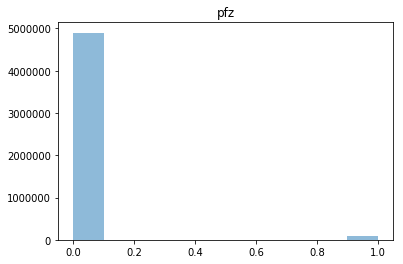

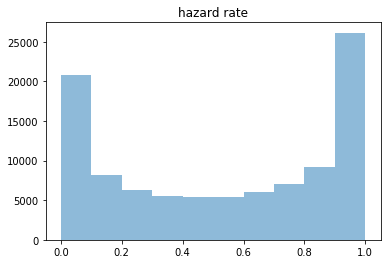

(2.7404282742745365, array([[1.1891073]], dtype=float32), 3.0534008999636475) 0.5323721541964066 0.3680374563554545
num of s and q 1000 50
probs calced
realisation complete
sns complete


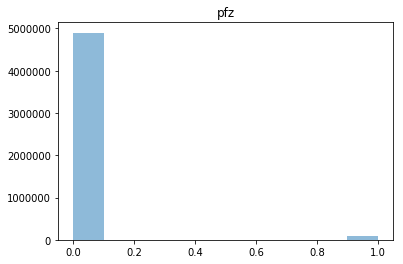

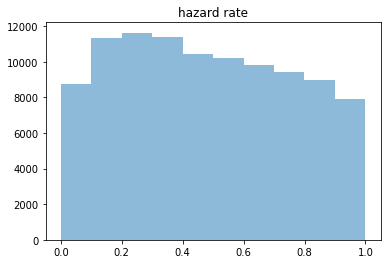

(0.5485235883413172, array([[0.1902643]], dtype=float32), 1.4830380323002723) 0.4798605104275527 0.27659764015497734
num of s and q 1000 50
probs calced
realisation complete
sns complete


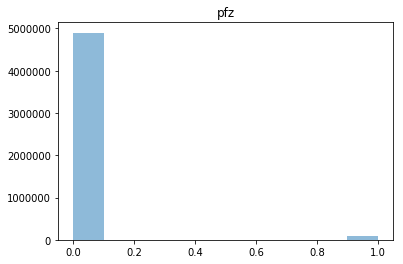

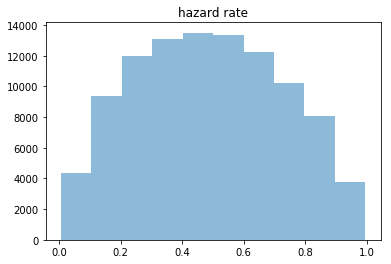

(1.3267137457020861, array([[0.04795493]], dtype=float32), 1.0350968986209508) 0.4875837080969234 0.23661533930790027
num of s and q 1000 50
probs calced
realisation complete
sns complete


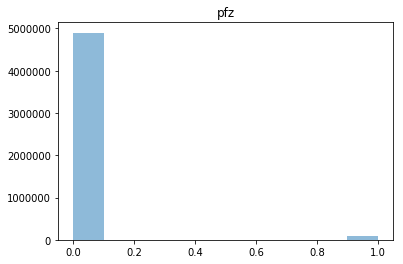

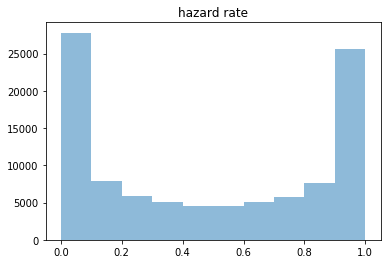

(0.9972894765069206, array([[1.2266152]], dtype=float32), 3.7767528729817528) 0.4877820400601681 0.3862088143367276
num of s and q 1000 50
probs calced
realisation complete
sns complete


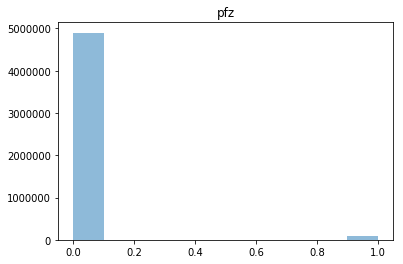

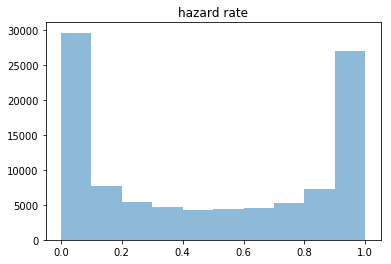

(2.2878670133535564, array([[1.1868775]], dtype=float32), 4.072381210314514) 0.4850967334966862 0.394688102141449
num of s and q 1000 50
probs calced
realisation complete
sns complete


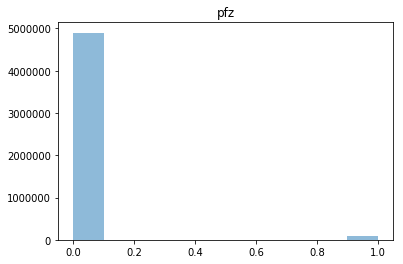

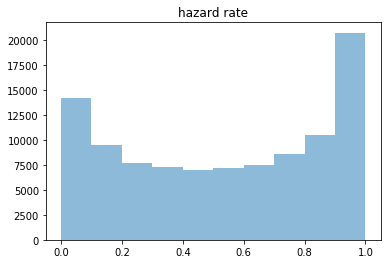

(2.0788277200632095, array([[0.653229]], dtype=float32), 2.242401975913643) 0.537068157963709 0.33412227949069234
num of s and q 1000 50
probs calced
realisation complete
sns complete


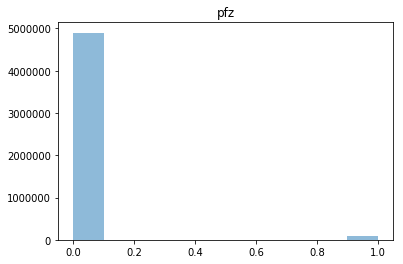

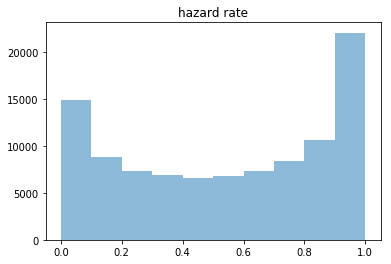

(2.0815435995726577, array([[0.74135804]], dtype=float32), 2.381851047214897) 0.5437983452646808 0.33932674659132855
num of s and q 1000 50
probs calced
realisation complete
sns complete


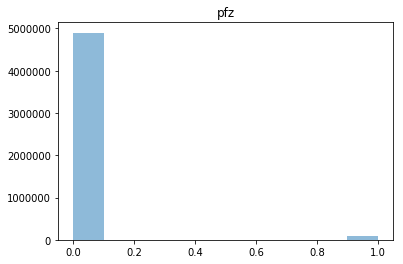

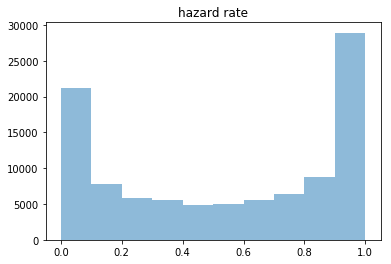

(3.109814359791683, array([[1.2541413]], dtype=float32), 3.2758833453626854) 0.5423809648927821 0.3758978602358108
num of s and q 1000 50
probs calced
realisation complete
sns complete


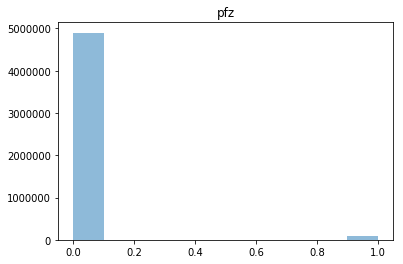

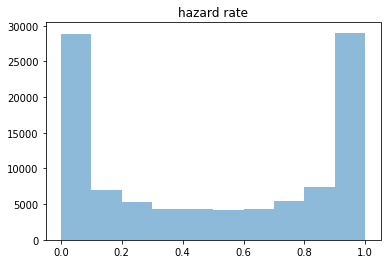

(1.8159307184205475, array([[1.2086667]], dtype=float32), 4.086161866853107) 0.5025337782876175 0.39805550997455114
num of s and q 1000 50
probs calced
realisation complete
sns complete


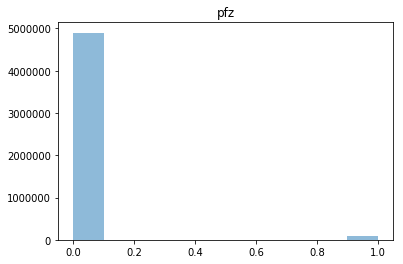

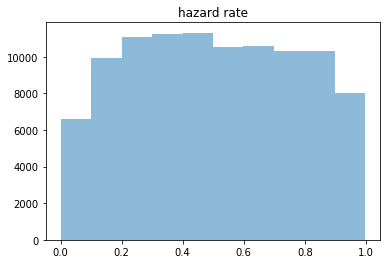

(1.6622405795665345, array([[0.16953261]], dtype=float32), 1.25446504533938) 0.5039455538180924 0.26906529637307375


In [52]:
for dataset_num in range(n_runs):
    (tw,a0,a1, ss, qs) = pickle.load(open("./synth_data/MLTM_1000_50_(20_1_3)_{}.p".format(dataset_num), "rb"))
    print("num of s and q", len(ss), len(qs))
    
    tr_pairs = get_pairs(ss, qs)
    check_balance_ixs = numpy.random.choice(range(len(tr_pairs)), size=100000)
    pairs_for_check_balance = numpy.array(tr_pairs)[check_balance_ixs,:]
    pfz, sz, qz, _ = stitch_n_split(pairs_for_check_balance, ss, qs, realise=True, rpt=True)

    probs=[]
    for si,qi in pairs_for_check_balance:
        probs.append(calc_probs(ss[si].reshape(1,-1), qs[qi].reshape(1,-1) ))
        
    plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
    plt.title("pfz")
    plt.show()

    plt.hist(numpy.array(probs).flatten(), alpha=0.5)
    plt.title("hazard rate")
    plt.show()

    mn = numpy.mean(probs)
    std = numpy.std(probs)
    print((tw,a0,a1), mn, std)

In [55]:
dataset_num = 2
(tw,a0,a1, ss, qs) = pickle.load(open("./synth_data/MLTM_1000_50_(20_1_3)_{}.p".format(dataset_num), "rb"))
print("num of s and q", len(ss), len(qs))

for s in ss:
    print(s)
    
for q in qs:
    print(q)

num of s and q 1000 50
[-0.43138476 -0.05824162 -2.21116995  1.69783923 -1.85637961 -0.87129009
  0.520531   -1.28899384 -1.09508306 -0.94091096  0.57080837  2.37265741
  0.0429973  -1.15716116  0.5579776  -0.61708306 -0.01980192  1.21624012
 -0.7741189   0.00934201]
[-9.08926757e-01 -1.61924525e-01  2.65575279e-01 -1.02348213e+00
 -3.50713566e-01 -2.44473358e-01 -6.60034726e-01 -1.22929379e+00
 -1.47109754e+00 -1.58882401e-01 -2.78500025e-01  2.30968084e+00
 -2.52022037e+00  1.16682856e-01  3.83445991e-01  1.40735279e+00
  5.19470838e-01 -8.73842987e-01  1.01040690e-05  5.61387465e-01]
[-0.32451136  0.79807186 -1.93365484  1.79194388  1.51918896 -0.34745857
  0.63279694  0.04965421 -0.85823537  0.09078858  1.03547563 -0.39446768
 -0.38885425 -0.07708446  0.44871071  1.32324638 -0.65695458  0.52623937
  0.22370101 -1.92384392]
[-0.43403319 -0.13697323 -0.04095903  0.33744514 -2.11193206  0.04787895
 -0.70145989 -1.48995887  0.54269761  0.76108561 -0.67617733  0.87202388
 -0.39490653  0

  1.49660392  0.18714927]
[-2.07943777  0.62839713  0.72598713 -2.26648937 -0.48831344 -0.35879244
 -0.67826184  0.24901898  1.23455527  1.49503123 -0.08995575 -0.17829765
 -0.76931079 -0.37813518 -1.23347405  0.92549663 -0.42970135 -0.3642236
 -0.57966569 -0.75337513]
[ 1.53710064  1.77260632  0.05884569 -0.16634425 -2.30297944  1.65475344
  0.99484847  0.20148795  0.96725703 -0.59319056 -2.2025379  -0.92335101
 -0.56274366  0.41666647  1.30626808 -1.20715112 -1.71931427 -0.33871277
  1.77821936  1.4576928 ]
[-1.35220724  1.74597894  0.81996174 -0.79376203 -0.71769086 -0.79268873
 -1.11254403 -0.37123057  1.3915732   0.67901948 -1.32974908  1.59688801
  1.13661654  0.41989848  1.2442809  -1.17796069 -0.48014942  0.15072179
  0.11538287  0.43480931]
[-0.11264085 -1.14742846 -0.44146371  0.09794294  1.43645823  0.36107613
  1.08060828  0.65887669 -0.44276334  1.7682271  -2.93483431 -0.88617106
  0.91325737  1.78908425 -1.58650515 -0.27220385 -2.72272665 -0.77691791
  1.22995377 -0.20544

50000
probs calced
realisation complete
sns complete


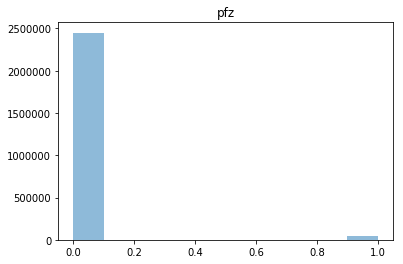

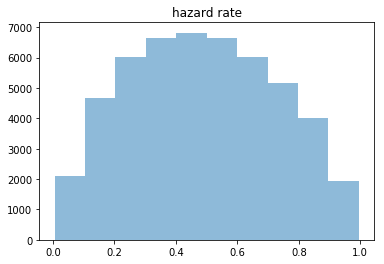

(1.3267137457020861, array([[0.04795493]], dtype=float32), 1.0350968986209508) 0.48812685078004253 0.23632819424389986
       student_id  question_id  pr_correct  correct
0             276            6    0.679204     True
1             276           33    0.266301    False
2             276           19    0.321521    False
3             276           27    0.690964    False
4             276            9    0.199842    False
5             276            1    0.623422     True
6             276            0    0.811848     True
7             276           11    0.119182    False
8             276           14    0.494298     True
9             276           26    0.686103     True
10            276            5    0.504753    False
11            276           35    0.113244    False
12            276            3    0.851075     True
13            276           23    0.511212     True
14            276            7    0.726405     True
15            276           15    0.166408     Tr

In [70]:
tr_pairs = get_pairs(ss, qs)
# for pair in tr_pairs:
#     print(pair)

# check_balance_ixs = numpy.random.choice(range(len(tr_pairs)), size=100000)
# pairs_for_check_balance = numpy.array(tr_pairs)[check_balance_ixs,:]
pairs_for_check_balance = tr_pairs
print(len(pairs_for_check_balance))
pfz, sz, qz, _ = stitch_n_split(pairs_for_check_balance, ss, qs, realise=True, rpt=True)

probs=[]
for_df = []
for si,qi in tr_pairs:# pairs_for_check_balance:
    pr = calc_probs(ss[si].reshape(1,-1), qs[qi].reshape(1,-1) )
    probs.append(pr)
    ob = numpy.random.random() < pr
    for_df.append([si, qi, float(pr), bool(ob)])
    
plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
plt.title("pfz")
plt.show()

plt.hist(numpy.array(probs).flatten(), alpha=0.5)
plt.title("hazard rate")
plt.show()

mn = numpy.mean(probs)
std = numpy.std(probs)
print((tw,a0,a1), mn, std)

import pandas
df = pandas.DataFrame(for_df, columns = ["student_id","question_id","pr_correct","correct"])
print(df)
df.to_csv("./synth_data/synth_exam_(20_1-3)_1000s_50q.csv")